<center><img src="https://souranshi.in/wp-content/uploads/2023/11/Best-movies-on-netflix-right-now.jpeg" style="width: 800px;"/>

# Netflix Recommendation Engine

## Problem Statement:
    
Customer Behaviour and it’s prediction lies at the core of every Business Model. From Stock Exchange, e-Commerce and Automobile to even Presidential Elections, predictions serve a great purpose. Most of these predictions are based on the data available about a person’s activity either online or in-person.

Recommendation Engines are the much needed manifestations of the desired Predictability of User Activity. Recommendation Engines move one step further and not only give information but put forth strategies to further increase users interaction with the platform.

In today’s world OTT platform and Streaming Services have taken up a big chunk in the Retail and Entertainment industry. Organizations like Netflix, Amazon etc. analyse User Activity Pattern’s and suggest products that better suit the user needs and choices.

For the purpose of this Project we will be creating one such Recommendation Engine from the ground-up, where every single user, based on there area of interest and ratings, would be recommended a list of movies that are best suited for them.

### Import important libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings("ignore")

# numpy & pandas
import numpy as np
import pandas as pd
import math 

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#conda install -c conda-forge scikit-surprise

In [3]:
#!pip install scikit-surprise

In [4]:
# import libraries for model building
import math
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

### Data Loading and Exploration:
+ Loading the dataset.
+ Exploring the dataset to understand its structure and properties such as the number of customers, ratings, and movies.

In [5]:
# Reading dataset file
data = pd.read_csv('combined_data_1.txt.zip',header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
data.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [6]:
data.dtypes #checking datatypes

Cust_Id     object
Rating     float64
dtype: object

In [7]:
data.shape #shape of dataset

(24058263, 2)

In [8]:
#get the customer count with NaN values
movie_count = data.isnull().sum()
movie_count

Cust_Id       0
Rating     4499
dtype: int64

In [9]:
#to claculate how many customers we are having in the dataset
customer_count=data['Cust_Id'].nunique()
customer_count

475257

In [10]:
#without NaN values
customer_count = data['Cust_Id'].nunique()-movie_count
customer_count

Cust_Id    475257
Rating     470758
dtype: int64

In [11]:
#get the total number of ratings given by the customers
rating_count = data['Cust_Id'].count()-movie_count
rating_count

Cust_Id    24058263
Rating     24053764
dtype: int64

In [12]:
#To find out how many people have rated the movies as 1, 2, 3,4,5 stars ratings to the movies
stars = data.groupby('Rating')['Rating'].agg(['count'])

In [13]:
stars

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


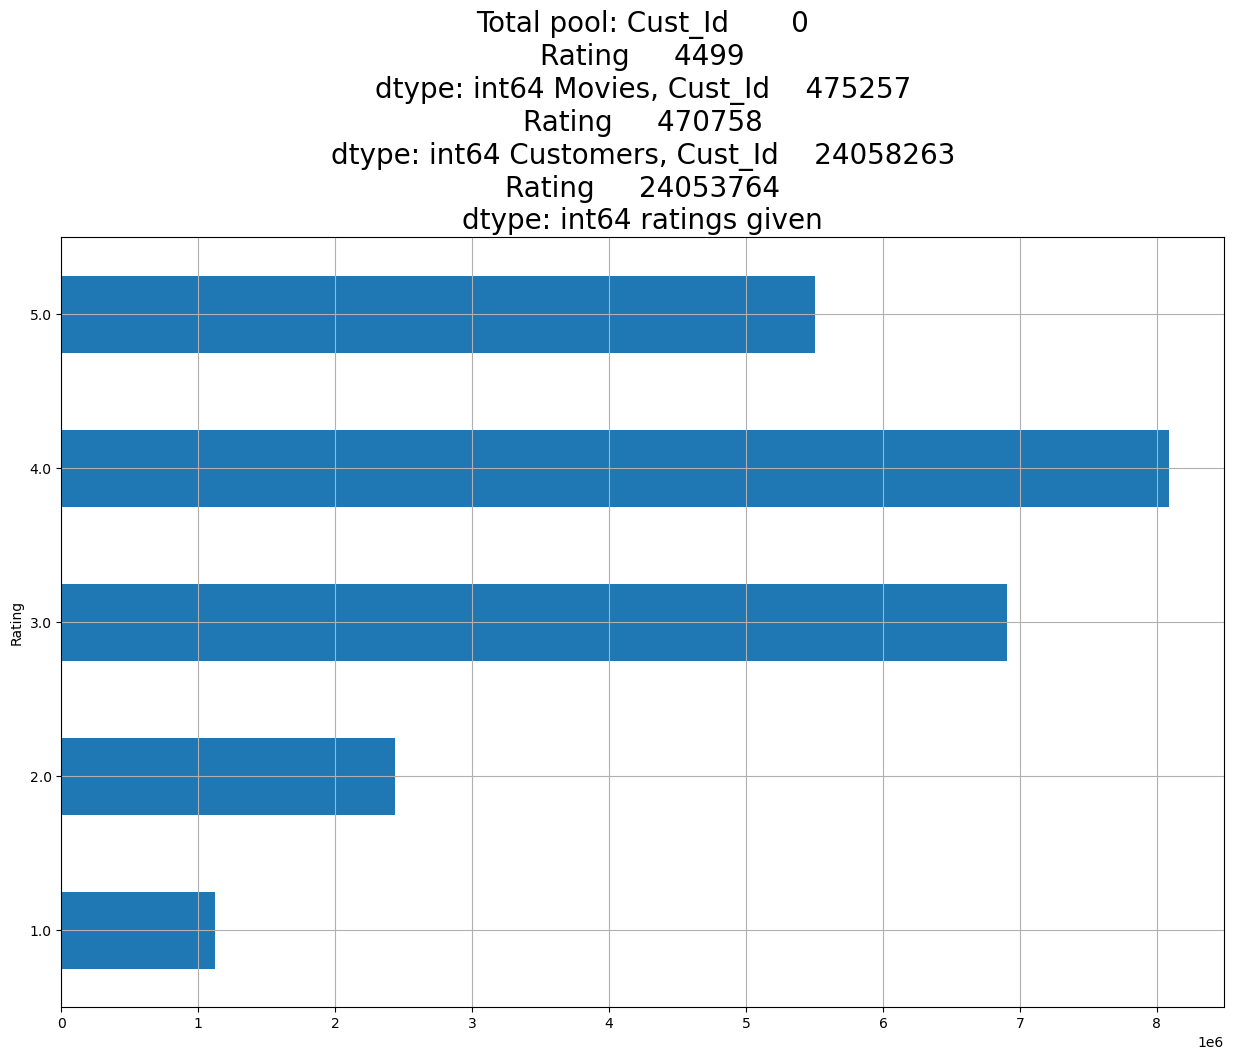

In [14]:
# To plot the distribution of the ratings in as a bar plot 
ax=stars.plot(kind='barh', legend=False, figsize=(15,10))
plt.title(f'Total pool: {movie_count} Movies, {customer_count} Customers, {rating_count} ratings given', fontsize=20)
plt.grid(True)

In [15]:
#Add another column that will have movie id
#first of all we will be calculating how many null values we are having in the ratings column
df_nan = pd.DataFrame(pd.isnull(data.Rating))

In [16]:
df_nan

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


In [17]:
df_nan=df_nan[df_nan['Rating']==True]
df_nan

,Rating
0,True
548,True
694,True
2707,True
2850,True
...,...
24046714,True
24047329,True
24056849,True
24057564,True


In [18]:
df_nan.shape

(4499, 1)

In [19]:
df_nan.head()

,Rating
0,True
548,True
694,True
2707,True
2850,True


In [20]:
df_nan.tail()

,Rating
24046714,True
24047329,True
24056849,True
24057564,True
24057834,True


In [21]:
#now we will reset the index as the column
df_nan=df_nan.reset_index()

In [22]:
#To create a numpy array containing movie ids according the 'ratings' dataset

movie_np = []
movie_id = 1
#into tuple
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [23]:
# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(data) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print(f'Movie numpy: {movie_np}')
print(f'Length: {len(movie_np)}')

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [24]:
#To append the above created array to the datset after removing the 'nan' rows
data = data[pd.notnull(data['Rating'])]#movies count so nan
data['Movie_Id'] = movie_np.astype(int)
data['Cust_Id'] =data['Cust_Id'].astype(int)
print("Now the dataset will look like: ")
data.head()

Now the dataset will look like: 


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [25]:
data.tail()

,Cust_Id,Rating,Movie_Id
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499
24058262,1704416,3.0,4499


### Data Preprocessing:
+ Handling missing values and converting data types.
+ Filtering out less active users and less frequently rated movies to improve computational efficiency.

In [26]:
f = ['count','mean']
#count and mean 

In [27]:
#To create a list of all the movies rated less often(only include top 30% rated movies)
dataset_movie_summary = data.groupby('Movie_Id')['Rating'].agg(f)

dataset_movie_summary.index = dataset_movie_summary.index.map(int)

movie_benchmark = round(dataset_movie_summary['count'].quantile(0.7),0)

drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1799.0


In [28]:
#To create a list of all the inactive users(users who rate less often)
dataset_cust_summary = data.groupby('Cust_Id')['Rating'].agg(f) #mean and count of customer id
dataset_cust_summary.index = dataset_cust_summary.index.map(int) #integer format
cust_benchmark = round(dataset_cust_summary['count'].quantile(0.7),0)
drop_cust_list = dataset_cust_summary[dataset_cust_summary['count'] < cust_benchmark].index
#                                           6                       <  5
#drop_cust_list[3,4]
print(f'Customer minimum times of review: {cust_benchmark}')


Customer minimum times of review: 52.0


In [29]:
print(f'Original Shape: {data.shape}')

Original Shape: (24053764, 3)


In [30]:
data = data[~data['Movie_Id'].isin(drop_movie_list)]
#in dataset --->in all movie ids------>if the whic ever  movies we put under drop list are present or not---
#if present drop /remove them
data = data[~data['Cust_Id'].isin(drop_cust_list)]
#removing all inactive users from our dataset
print('After Trim Shape: {}'.format(data.shape))

After Trim Shape: (17337458, 3)


In [31]:
print("Now the dataset will look like: ")
data.head()

Now the dataset will look like: 


,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [32]:
#Create ratings matrix for 'ratings' matrix with Rows = userId, Columns = movieId
df_p = pd.pivot_table(data,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [33]:
df_p.head()

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  loading the movie_titles dataset

In [34]:
df_title = pd.read_csv("movie_titles.csv",  encoding='ISO-8859-1', header=None, usecols=[0,1,2], names=['Movie_Id','Year','Name' ])

df_title.set_index('Movie_Id', inplace=True)

print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


### Singular Value Decomposition (SVD):
+ Using the Surprise library to perform matrix factorization using SVD.
+  Evaluating the model's performance using cross-validation.

In [35]:
# Load Reader library
reader = Reader()

# get just top 100K rows for faster run time
dataset = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm
cross_validate(svd, dataset, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9951  1.0003  0.9986  0.9980  0.0022  
MAE (testset)     0.8041  0.8065  0.7935  0.8014  0.0057  
Fit time          0.85    0.86    0.91    0.87    0.03    
Test time         0.20    0.19    0.29    0.22    0.04    


{'test_rmse': array([0.99511779, 1.00029999, 0.99862006]),
 'test_mae': array([0.80411669, 0.80647904, 0.79346912]),
 'fit_time': (0.8463349342346191, 0.8581662178039551, 0.9116008281707764),
 'test_time': (0.19728517532348633, 0.18892168998718262, 0.28527235984802246)}

In [36]:
data.head()

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


### Recommendation Generation:
+ Defining functions to retrieve highly rated movies for a given user and to generate recommendations based on predicted ratings.
+ Examples provided for generating recommendations for specific users.

In [37]:
# To find all the movies rated as 5 stars by user with userId = 712664

In [38]:
def get_highly_rated_movies(user_id, rating_threshold=5):
    # Filter the data to get movies rated 5 stars by the specified user
    user_movies = data[(data['Cust_Id'] == user_id) & (data['Rating'] == rating_threshold)]
    
    # Set the index to 'Movie_Id'
    user_movies = user_movies.set_index('Movie_Id')
    
    # Join with the movie titles DataFrame to get movie names
    user_movies = user_movies.join(df_title)['Name']
    
    return user_movies

### Example 1: user_id = 712664

In [39]:
# Example usage for user 712664:
user_id = 712664  # Change this to the desired user ID
highly_rated_movies = get_highly_rated_movies(user_id)
highly_rated_movies.head(10)

Movie_Id
3                              Character
79                           The Killing
175                       Reservoir Dogs
199                      The Deer Hunter
241                   North by Northwest
256    Ghost Dog: The Way of the Samurai
348        The Last Temptation of Christ
357                House of Sand and Fog
416                             Elephant
442                  Mississippi Burning
Name: Name, dtype: object

In [41]:
# Create a shallow copy for the movies dataset
user_712664 = df_title.copy()

user_712664 = user_712664.reset_index()

#To remove all the movies rated less often 
user_712664 = user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]


# getting full dataset
dataset = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating']], reader)

#create a training set for svd
trainset = dataset.build_full_trainset()
svd.fit(trainset)

#Predict the ratings for user_712664
user_712664['Estimate_Score'] = user_712664['Movie_Id'].apply(lambda x: svd.predict(712664, x).est)

#Drop extra columns from the user_712664 data frame
user_712664 = user_712664.drop('Movie_Id', axis = 1)

# Sort predicted ratings for user_712664 in descending order
user_712664 = user_712664.sort_values('Estimate_Score', ascending=False)

#Print top 10 recommendations
print(user_712664.head(10))


        Year                        Name  Estimate_Score
174   1992.0              Reservoir Dogs        5.000000
1031  1992.0                 Hard Boiled        5.000000
871   1954.0               Seven Samurai        5.000000
2101  1994.0      The Simpsons: Season 6        5.000000
1290  1960.0  The Twilight Zone: Vol. 19        5.000000
3289  1974.0               The Godfather        4.984894
2128  1960.0  The Twilight Zone: Vol. 41        4.966957
1855  1960.0  The Twilight Zone: Vol. 39        4.963805
1651  1961.0  The Twilight Zone: Vol. 37        4.943736
1688  2003.0          Concert for George        4.923114


### Example 2: user_id = 656399 

In [42]:
# Example usage for user 656399:
user_id = 656399 
highly_rated_movies = get_highly_rated_movies(user_id)
highly_rated_movies.head(10)

Movie_Id
571                                  American Beauty
1245                                       Threesome
1590                                 Life as a House
1707    Outfoxed: Rupert Murdoch's War on Journalism
3986                                   Life and Debt
Name: Name, dtype: object

In [43]:
# Create a shallow copy for the movies dataset
user_656399  = df_title.copy()

user_656399  = user_656399 .reset_index()

#To remove all the movies rated less often 
user_656399  = user_656399 [~user_656399 ['Movie_Id'].isin(drop_movie_list)]


# getting full dataset
dataset = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating']], reader)

#create a training set for svd
trainset = dataset.build_full_trainset()
svd.fit(trainset)

#Predict the ratings for user_656399 
user_656399 ['Estimate_Score'] = user_656399 ['Movie_Id'].apply(lambda x: svd.predict(656399, x).est)

#Drop extra columns from the user_656399  data frame
user_656399  = user_656399 .drop('Movie_Id', axis = 1)

# Sort predicted ratings for user_656399  in descending order
user_656399  = user_656399 .sort_values('Estimate_Score', ascending=False)

#Print top 10 recommendations
print(user_656399 .head(10))


        Year                                          Name  Estimate_Score
1740  1999.0                            Cowboy Bebop Remix        4.308652
1706  2004.0  Outfoxed: Rupert Murdoch's War on Journalism        4.234691
4344  2002.0                         Bowling for Columbine        4.229127
1617  1984.0            Nausicaa of the Valley of the Wind        4.196623
1475  2004.0                      Six Feet Under: Season 4        4.163465
3455  2004.0                                Lost: Season 1        4.085794
2328  2004.0                                  Control Room        4.084439
3985  2001.0                                 Life and Debt        4.076505
2802  1995.0                           Pride and Prejudice        4.066963
3445  2002.0                                 Spirited Away        4.065641


### Example 3: user_id = 2632461  

In [44]:
# Example usage for user 2632461:
user_id = 2632461  
highly_rated_movies = get_highly_rated_movies(user_id)
highly_rated_movies.head(10)

Movie_Id
798                                      Jaws
1144                     Fried Green Tomatoes
1180                         A Beautiful Mind
3605    The Wizard of Oz: Collector's Edition
Name: Name, dtype: object

In [45]:
# Create a shallow copy for the movies dataset
user_2632461  = df_title.copy()

user_2632461 = user_2632461 .reset_index()

#To remove all the movies rated less often 
user_2632461  = user_2632461 [~user_2632461 ['Movie_Id'].isin(drop_movie_list)]


# getting full dataset
dataset = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating']], reader)

#create a training set for svd
trainset = dataset.build_full_trainset()
svd.fit(trainset)

#Predict the ratings for user_2632461
user_2632461['Estimate_Score'] = user_2632461['Movie_Id'].apply(lambda x: svd.predict(2632461, x).est)

#Drop extra columns from the user_2632461  data frame
user_2632461  = user_2632461 .drop('Movie_Id', axis = 1)

# Sort predicted ratings for user_2632461  in descending order
user_2632461  = user_2632461 .sort_values('Estimate_Score', ascending=False)

#Print top 10 recommendations
print(user_2632461.head(10))

        Year                                   Name  Estimate_Score
4426  2001.0                The West Wing: Season 3        4.488795
3443  2004.0  Family Guy: Freakin' Sweet Collection        4.417366
2101  1994.0                 The Simpsons: Season 6        4.340916
3455  2004.0                         Lost: Season 1        4.330925
1688  2003.0                     Concert for George        4.271866
222   2003.0             Chappelle's Show: Season 1        4.218191
3045  1990.0      The Simpsons: Treehouse of Horror        4.217135
3927  2004.0                     Nip/Tuck: Season 2        4.212488
2171  1991.0                 The Simpsons: Season 3        4.204344
1019  1989.0                 The Simpsons: Season 1        4.201272
